In [1]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer
from cluster_helper import ClusterProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv

from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
k_neighbors = 50
knn_clusters = 100
keep_k_evecs = 10
drop_k_evecs=2

cluster_assignments = pd.read_csv("./data/CLUSTER_ASSIGNMENTS.csv")
icd9codes = pd.read_csv("../../data/PATIENT_ICD_ICD9_CODES.csv")
patient_icd_binary = pickle.load(open("../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p", 'rb'))
icd9diag = pd.read_csv("../../../mimic/D_ICD_DIAGNOSES.csv.gz")
icd9proc = pd.read_csv("../../../mimic/D_ICD_PROCEDURES.csv.gz")

A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))

In [3]:
admin = pd.read_csv("/Users/andrew/Documents/meng/spring/mimic/DIAGNOSES_ICD.csv.gz")
admin.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [4]:
icd9diag.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [5]:
icd9codes

,ICD9_CODE
0,0030
1,0031
2,0038
3,0039
4,0041
...,...
6979,V902
6980,V9039
6981,V9081
6982,V9089


In [6]:
cluster_assignments[cluster_assignments['CLUSTER'] == 14] 

,SUBJECT_ID,ORIGINAL_INDEX,CLUSTER,MC_CLUSTER
24,64,27,14,0
111,62,121,14,0
235,226,257,14,88
258,267,284,14,24
270,440,296,14,88
...,...,...,...,...
42393,99823,46388,14,0
42436,99923,46434,14,88
42438,99934,46436,14,88
42454,97004,46453,14,88


In [7]:
cp = ClusterProcessor(patient_icd_binary, icd9codes, icd9diag, cluster_assignments, k_neighbors,
                        other_stopwords = ["hypertension", 'disorder'])

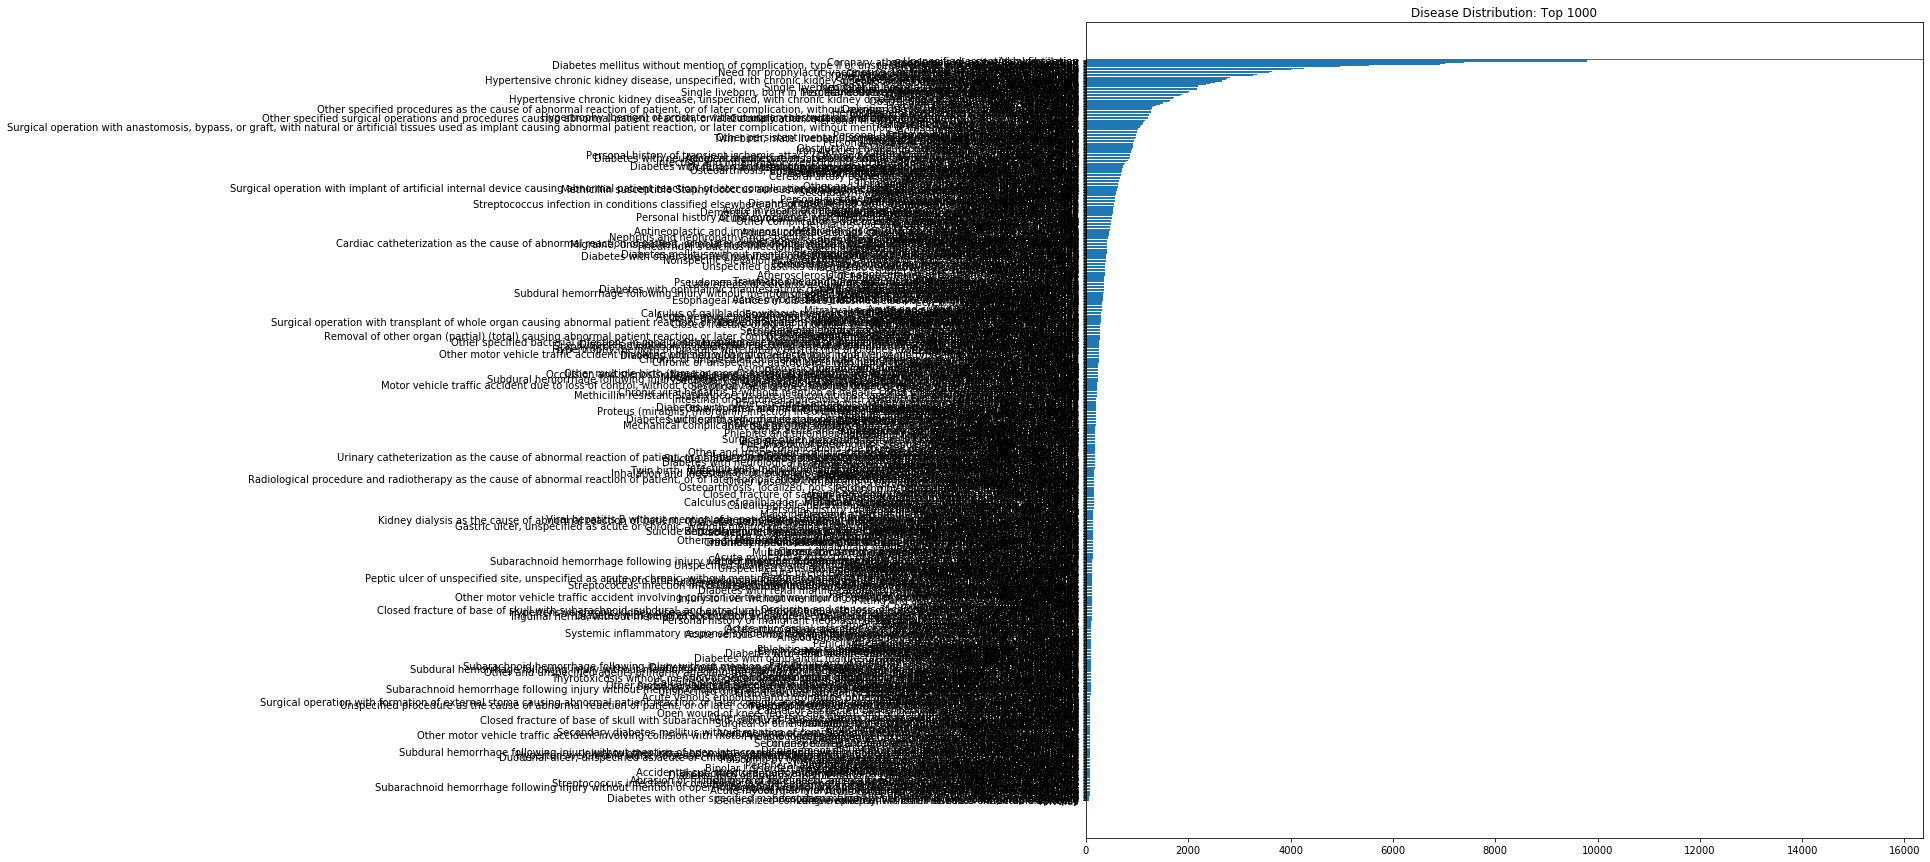

[('4019', 'Unspecified essential hypertension', 16361),
 ('42731', 'Atrial fibrillation', 9803),
 ('41401', 'Coronary atherosclerosis of native coronary artery', 9786),
 ('4280', 'Congestive heart failure, unspecified', 9405),
 ('5849', 'Acute kidney failure, unspecified', 7397),
 ('2724', 'Other and unspecified hyperlipidemia', 7016),
 ('25000',
  'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled',
  6921),
 ('51881', 'Acute respiratory failure', 6479),
 ('5990', 'Urinary tract infection, site not specified', 5538),
 ('53081', 'Esophageal reflux', 4971),
 ('2720', 'Pure hypercholesterolemia', 4796),
 ('2859', 'Anemia, unspecified', 4768),
 ('486', 'Pneumonia, organism unspecified', 4256),
 ('2851', 'Acute posthemorrhagic anemia', 4012),
 ('2762', 'Acidosis', 4005),
 ('V053',
  'Need for prophylactic vaccination and inoculation against viral hepatitis',
  3835),
 ('2449', 'Unspecified acquired hypothyroidism', 3633),
 ('V290', '

In [8]:
cp.plot_disease_distribution(topk=1000)

In [ ]:
diag = pd.read_csv("/Users/andrew/Documents/meng/spring/mimic/DIAGNOSES_ICD.csv.gz")

In [ ]:
diag[diag['ICD9_CODE'] =='9974']

In [ ]:
icd9diag[icd9diag['ICD9_CODE'] =='9974']

In [ ]:
cp.plot_disease_distribution(10, cluster=14)

In [ ]:
A_sorted = cp.sort_by_cluster_membership(A, mc_cluster=False)
A_mc_sorted = cp.sort_by_cluster_membership(A, mc_cluster=False)
# pickle.dump(A_sorted, open("./data/A_sorted_K{}.p".format(k_neighbors),"wb"))
# pickle.dump(A_mc_sorted, open("./data/A_mc_sorted_K{}.p".format(k_neighbors),"wb"))

In [ ]:
K = cp.build_cluster_matrix(mc_cluster=False)
K_mc = cp.build_cluster_matrix(mc_cluster=True)
pickle.dump(K, open("./data/K_K{}_knn{}.p".format(k_neighbors, knn_clusters), "wb"))
pickle.dump(K_mc, open("./data/K_mc_K{}_knn{}.p".format(k_neighbors, knn_clusters), "wb"))

In [ ]:
KA = K.T.dot(A_sorted)
KA_mc = K_mc.T.dot(A_mc_sorted)

KAK = K.T.dot(A_sorted).dot(K)
KAK_mc = K_mc.T.dot(A_mc_sorted).dot(K_mc)

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(KAK.toarray(), cmap="Blues")

In [ ]:
lc=100

Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

Y_mc_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
Y_mc_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

Y_c_umap_2d = cp.compute_centroids(Y_umap_2d, mc_cluster=False)
Y_c_umap_3d = cp.compute_centroids(Y_umap_3d, mc_cluster=False)
Y_mc_c_umap_2d = cp.compute_centroids(Y_mc_umap_2d, mc_cluster=True)
Y_mc_c_umap_3d = cp.compute_centroids(Y_mc_umap_3d, mc_cluster=True)

In [ ]:
def create_centroid_cluster_df(y, cluster_labels, topk=3):
    centroids = cp.compute_centroids(y, mc_cluster=False)
    
    x = centroids[:, 0].tolist()
    y = centroids[:, 1].tolist()
    cluster_sizes = np.unique(cluster_labels, return_counts=True)[1].tolist()
        
    titles = ["" for _ in range(centroids.shape[0])]
    # print(len(titles))
    for c in tqdm(np.unique(cluster_labels)):
        top_k_df = cp.top_diseases_in_cluster(cluster=c, topk=3, short_title=True)
        # print(top_k_df)
        top_k_titles = top_k_df["SHORT_TITLE"].values.tolist()
        # print(top_k_titles)
        top_k_titles_asstr = "\n".join(top_k_titles)
        # print(top_k_titles_asstr)
        titles[c] = top_k_titles_asstr
        # break
        
        
    centroid_dict = {"x": x,
                     "y": y,
                     "cluster_size": cluster_sizes,
                     "cluster": np.unique(cluster_labels).tolist(),
                     "title": titles
                    }
    
    if centroids.shape[-1] == 3:
        z = centroids[:, 2].tolist()
        centroid_dict['z'] = z
        
    return pd.DataFrame(centroid_dict)

print(np.unique(Y_cluster_labels))


Y_2d_df = create_centroid_cluster_df(Y_umap_2d, Y_cluster_labels)
print("Done")
plt.figure(figsize=(40,40))
ax = sns.scatterplot(x="x", y="y", size="cluster_size", hue="cluster",
            sizes=(300, 2000), alpha=.5, palette="muted",
            data=Y_2d_df)
for line in tqdm(range(0,Y_2d_df.shape[0])):
     ax.text(Y_2d_df.x[line], Y_2d_df.y[line], Y_2d_df.title[line])

h,l = ax.get_legend_handles_labels()
plt.legend(h[-5:], l[-5:], loc="upper right")

plt.savefig("./figures/CLUSTER_PLOT_TOP_WORDS.png")